In [1]:
# this script is an equivalent of bash file download_2d_prespective.sh
# it downloads the 2D perspective images from the KITTI-360 dataset
# and extracts the images from the zip files

# Additional information (This part is implemented based on Julia's e-mail):
# This scripts retains every 5th image in the data_rect folder and deletes the rest
# This is done to reduce the number of images in the dataset
# The total number of images in the dataset is printed at the end

import os
import zipfile
import urllib.request

train_list = [
    "2013_05_28_drive_0000_sync",
    #"2013_05_28_drive_0002_sync",
    #"2013_05_28_drive_0003_sync",
    #"2013_05_28_drive_0004_sync",
    #"2013_05_28_drive_0005_sync",
    #"2013_05_28_drive_0006_sync",
    #"2013_05_28_drive_0007_sync",
    #"2013_05_28_drive_0009_sync",
    #"2013_05_28_drive_0010_sync"
]

# cam_list = ["00", "01"]
cam_list = ["00"]

root_dir = "datasets/data_1/KITTI-360"
data_2d_dir = "data_2d_raw"

os.makedirs(os.path.join(root_dir, data_2d_dir), exist_ok=True)

# Change the current working directory to root_dir
os.chdir(root_dir)

total_images = 0

# Perspective images
for sequence in train_list:
    for camera in cam_list:
        zip_file = f"{sequence}_image_{camera}.zip"
        url = f"https://s3.eu-central-1.amazonaws.com/avg-projects/KITTI-360/data_2d_raw/{zip_file}"
        local_zip_path = os.path.join(data_2d_dir, zip_file)
        
        # Download the zip file
        urllib.request.urlretrieve(url, local_zip_path)
        
        # Unzip the file
        with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_2d_dir)
        
        # Remove the zip file
        os.remove(local_zip_path)

# Print the cumulative sum
# print(f"Total number of images across all folders: {total_images}")

In [2]:
image_dir = os.path.join(data_2d_dir, sequence, f"image_{camera}", "data_rect")
print(f"Total number of images in the dataset: {len(os.listdir(image_dir))}")

Total number of images in the dataset: 11518


In [1]:
import os
images = []
image_dir = "datasets/data_1/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect"
if os.path.exists(image_dir):
    images = sorted(os.listdir(image_dir))
    print(f"Total number of images in the dataset: {len(images)}")

print(image_dir)
print(images)



Total number of images in the dataset: 11518
datasets/data_1/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect
['0000000000.png', '0000000001.png', '0000000002.png', '0000000003.png', '0000000004.png', '0000000005.png', '0000000006.png', '0000000007.png', '0000000008.png', '0000000009.png', '0000000010.png', '0000000011.png', '0000000012.png', '0000000013.png', '0000000014.png', '0000000015.png', '0000000016.png', '0000000017.png', '0000000018.png', '0000000019.png', '0000000020.png', '0000000021.png', '0000000022.png', '0000000023.png', '0000000024.png', '0000000025.png', '0000000026.png', '0000000027.png', '0000000028.png', '0000000029.png', '0000000030.png', '0000000031.png', '0000000032.png', '0000000033.png', '0000000034.png', '0000000035.png', '0000000036.png', '0000000037.png', '0000000038.png', '0000000039.png', '0000000040.png', '0000000041.png', '0000000042.png', '0000000043.png', '0000000044.png', '0000000045.png', '0000000046.png', '0000000047.png', '00000

In [2]:
from weaklabelgenerator_v1 import labelgenerator
import network
model = 'deeplabv3plus_resnet101'
ckpt = "checkpoints/best_deeplabv3plus_resnet101_cityscapes_os16.pth"
model = network.modeling.__dict__[model](num_classes=19, output_stride=16)

# Create an empty list to store the full paths
image_paths = []

# Iterate through the images list and build the full paths
for image in images:
    full_path = os.path.join(image_dir, image)
    image_paths.append(full_path)

sample = image_paths

labelgen = labelgenerator(sample, model, ckpt)

Resume model from checkpoints/best_deeplabv3plus_resnet101_cityscapes_os16.pth


100%|██████████| 11518/11518 [34:50<00:00,  5.51it/s]


Saved image and label paths to outputs/weaklabels/KITTI-360/image_entropy.json


In [4]:
import json
import numpy as np

def filter_rich_data(json_file_path, entropy_threshold=0.20, confidence_threshold=0.85, min_class_count=10):
    # Load the JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Filter entries based on confidence and class count
    filtered_data = [
        entry for entry in data 
        if float(entry["entropy"]) >= entropy_threshold 
        and float(entry['confidence']) >= confidence_threshold 
        and int(entry['class_count']) >= min_class_count
    ]

    # Sort the filtered data by entropy (descending) to prioritize rich data representation
    filtered_data.sort(key=lambda x: float(x['entropy']), reverse=True)

    print(f"Total entries: {len(data)}")
    print(f"Filtered entries: {len(filtered_data)}")

    return filtered_data

# Usage
json_file_path = 'outputs/weaklabels/KITTI-360/image_entropy.json'
filtered_entries = filter_rich_data(json_file_path, entropy_threshold=0.20, confidence_threshold=0.85, min_class_count=10)

# Optionally, save the filtered entries to a new JSON file
if filtered_entries:
    with open('outputs/weaklabels/KITTI-360/filtered_data.json', 'w') as file:
        json.dump(filtered_entries, file, indent=4)
    print(f"Filtered data saved to 'outputs/weaklabels/KITTI-360/filtered_data.json'")
else:
    print("No entries matched the filter criteria.")

Total entries: 11518
Filtered entries: 2123
Filtered data saved to 'outputs/weaklabels/KITTI-360/filtered_data.json'


In [1]:
from vdna import VDNAProcessor, EMD, load_vdna_from_files

c:\Users\sumal\anaconda3\envs\temp_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
xFormers not available
xFormers not available


In [4]:
import os
import torch
vdna_proc = VDNAProcessor()
device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Configuration dictionary to manage paths
config = {
    "cityscapes_base_path": "datasets/data/cityscapes/leftImg8bit/train/",
    "vdna_output_path": "outputs/weaklabels/KITTI-360/vdna_cityscapes"
}

# Ensure output directory exists
output_path = config["vdna_output_path"]
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Ensure paths exist
#for key, path in config.items():
#    if not os.path.exists(path):
#        raise FileNotFoundError(f"Path for {key} does not exist: {path}")

# Get all city directories at the same level as aachen, bochum, etc.
cityscapes_base_path = config["cityscapes_base_path"]
city_dirs = [os.path.join(cityscapes_base_path, city) for city in os.listdir(cityscapes_base_path) if os.path.isdir(os.path.join(cityscapes_base_path, city))]

# Collect all image paths from all city directories
all_image_paths = []
for city in city_dirs:
    for root, _, files in os.walk(city):
        for file in files:
            if file.endswith(".png"):  # Assuming images are in PNG format
                all_image_paths.append(os.path.join(root, file))

# Process all images collectively
vdna_cityscapes = vdna_proc.make_vdna(source=all_image_paths, device=device, num_workers=0, feat_extractor_name="dinov2_small_224")

# Ensure output directory exists
#output_path = config["vdna_output_path"]
#os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save the results
vdna_cityscapes.save(output_path)

results = []

Found 2975 images in the provided source
Using 2975 images


  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [07:58<00:00, 10.18s/it]


In [4]:
from vdna import VDNAProcessor, EMD, load_vdna_from_files
import json
import os
import torch

device = torch.device('cpu')
device = "cuda:0" if torch.cuda.is_available() else "cpu"


vdna_proc = VDNAProcessor()

# Configuration dictionary
config = {
    "input_json_path": "outputs/weaklabels/KITTI-360/filtered_data.json",
    "output_json_path": "outputs/weaklabels/KITTI-360/results_emd.json",
    "vdna_cityscapes_path": "outputs/weaklabels/KITTI-360/vdna_cityscapes",  # Adjust this path as needed
    "vdna_kitti_path": "outputs/weaklabels/KITTI-360/kitti_360"
}


# Load the input JSON file
with open(config["input_json_path"], 'r') as json_file:
    data = json.load(json_file)

# Load the pre-computed Cityscapes VDNA
vdna_cityscapes = load_vdna_from_files(config["vdna_cityscapes_path"])

# Process images and compute EMD
for item in data:
    image_path = item["image_path"]
    
    if os.path.exists(image_path):
        # Compute VDNA for the current image
        vdna_kitti = vdna_proc.make_vdna(source=image_path, device=device, num_workers=0, feat_extractor_name="dinov2_small_224")
        vdna_kitti.save(config["vdna_kitti_path"])

        vdna_kitti_load = load_vdna_from_files(config["vdna_kitti_path"])
        
        # Calculate EMD
        emd = EMD(vdna_cityscapes, vdna_kitti_load)
        
        # Convert tensor to float
        if isinstance(emd, torch.Tensor):
            emd = emd.item()
        
        # Add EMD to the item
        item["emd"] = float(emd)
    else:
        print(f"Warning: Image file not found: {image_path}")
        item["emd"] = None

# Sort the results by EMD
data = sorted(data, key=lambda x: x['emd'] if x['emd'] is not None else float('inf'))

# Save the results to a JSON file
os.makedirs(os.path.dirname(config["output_json_path"]), exist_ok=True)

with open(config["output_json_path"], 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Processing complete. Updated JSON saved as '{config['output_json_path']}'.")

Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 images in the provided source
Using 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Processing complete. Updated JSON saved as 'outputs/weaklabels/KITTI-360/results_emd.json'.


C:\Users\sumal\AppData\Local\Temp\ipykernel_12596\2610976138.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)


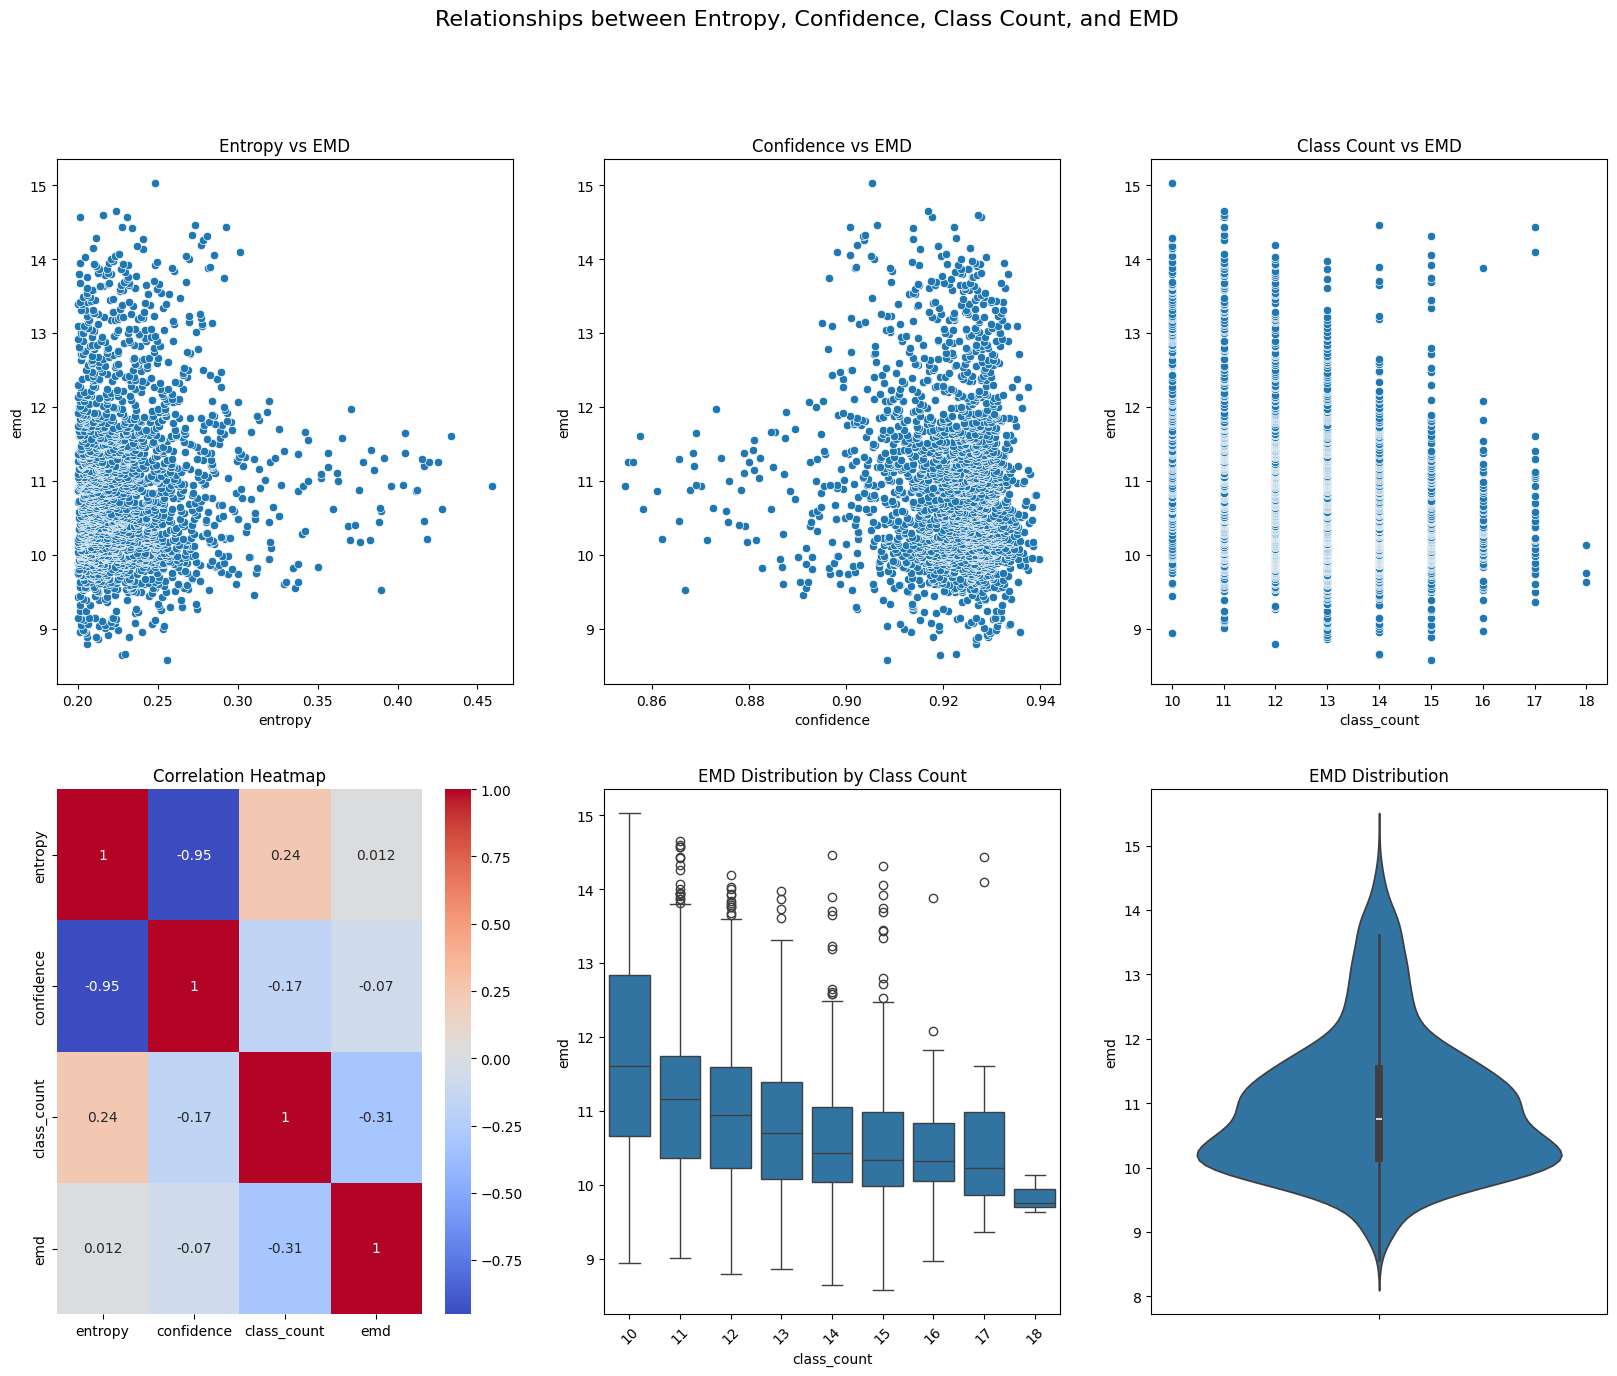

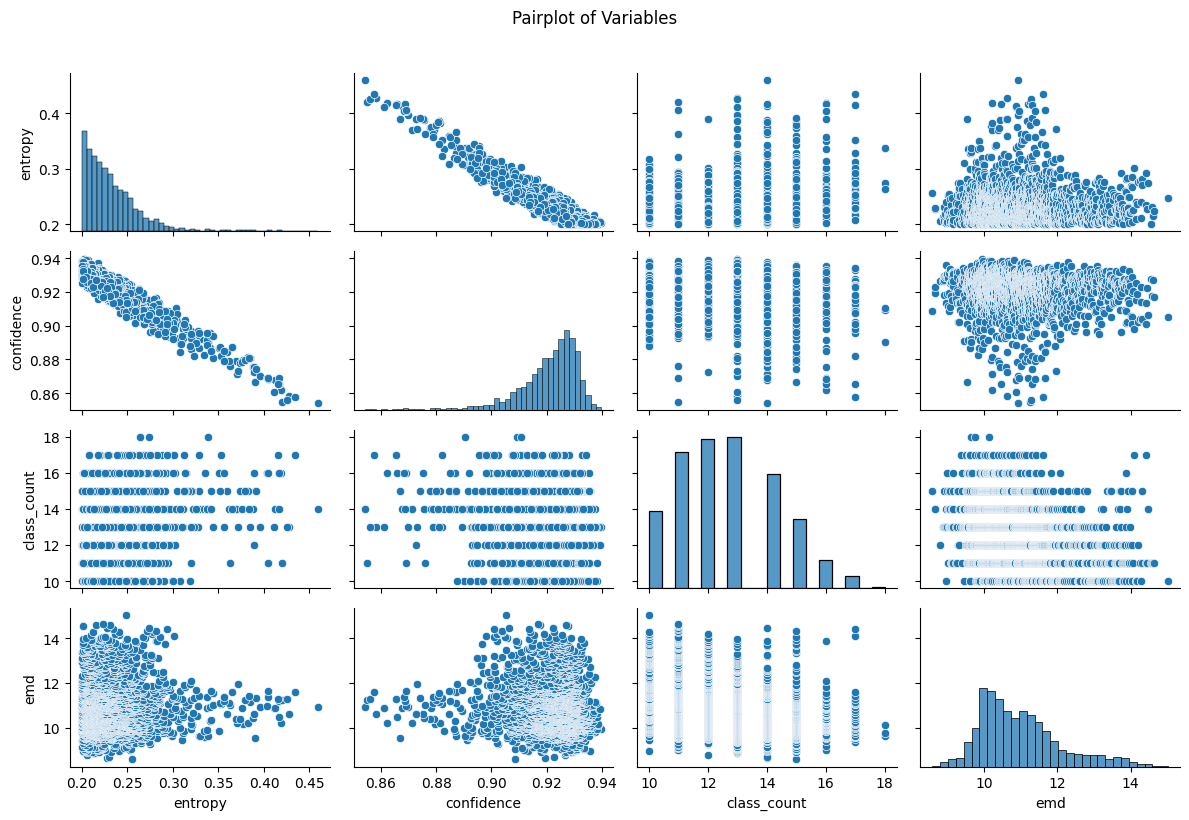

           entropy   confidence  class_count          emd
count  2123.000000  2123.000000  2123.000000  2123.000000
mean      0.234760     0.920470    12.643429    10.965454
std       0.034102     0.011445     1.712222     1.104684
min       0.200018     0.854405    10.000000     8.574124
25%       0.211406     0.915665    11.000000    10.150134
50%       0.225843     0.923214    13.000000    10.763608
75%       0.247844     0.928151    14.000000    11.536472
max       0.459186     0.939764    18.000000    15.030257

Correlation Coefficients:
emd            1.000000
entropy        0.012444
confidence    -0.070154
class_count   -0.311618
Name: emd, dtype: float64


In [5]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Read the JSON file
with open('outputs/weaklabels/KITTI-360/results_emd.json', 'r') as f:
    data = json.load(f)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Create a figure with multiple subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Relationships between Entropy, Confidence, Class Count, and EMD', fontsize=16)

# 1. Scatter plot: Entropy vs EMD
sns.scatterplot(data=df, x='entropy', y='emd', ax=axs[0, 0])
axs[0, 0].set_title('Entropy vs EMD')

# 2. Scatter plot: Confidence vs EMD
sns.scatterplot(data=df, x='confidence', y='emd', ax=axs[0, 1])
axs[0, 1].set_title('Confidence vs EMD')

# 3. Scatter plot: Class Count vs EMD
sns.scatterplot(data=df, x='class_count', y='emd', ax=axs[0, 2])
axs[0, 2].set_title('Class Count vs EMD')

# 4. Heatmap: Correlation matrix
corr = df[['entropy', 'confidence', 'class_count', 'emd']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[1, 0])
axs[1, 0].set_title('Correlation Heatmap')

# 5. Pairplot
sns.pairplot(df[['entropy', 'confidence', 'class_count', 'emd']], height=2, aspect=1.5)
plt.suptitle('Pairplot of Variables', y=1.02)

# 6. Box plot: EMD distribution by Class Count
sns.boxplot(data=df, x='class_count', y='emd', ax=axs[1, 1])
axs[1, 1].set_title('EMD Distribution by Class Count')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)

# 7. Violin plot: EMD distribution
sns.violinplot(data=df, y='emd', ax=axs[1, 2])
axs[1, 2].set_title('EMD Distribution')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Additional analysis: Calculate and print summary statistics
print(df[['entropy', 'confidence', 'class_count', 'emd']].describe())

# Calculate and print correlation coefficients
print("\nCorrelation Coefficients:")
print(corr['emd'].sort_values(ascending=False))

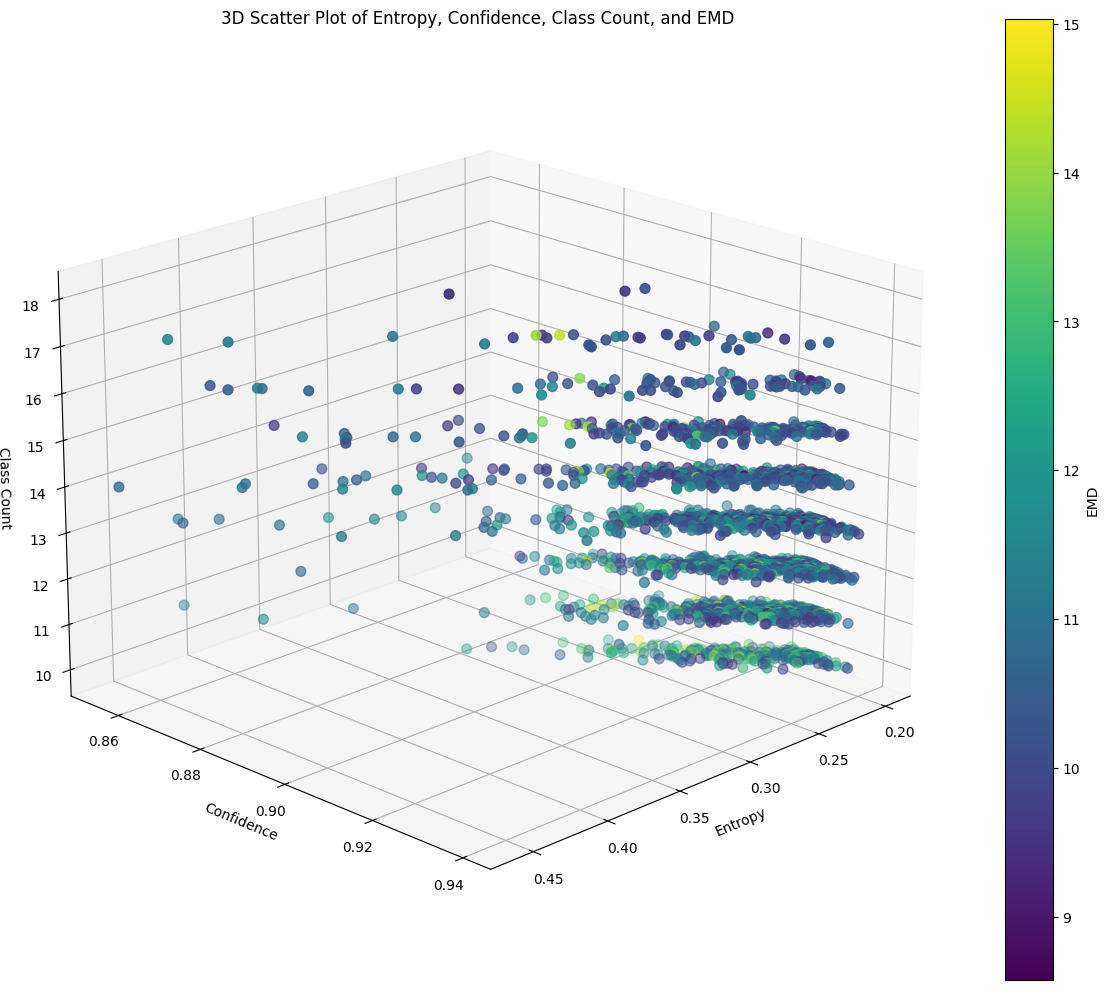

           entropy   confidence  class_count          emd
count  2123.000000  2123.000000  2123.000000  2123.000000
mean      0.234760     0.920470    12.643429    10.965454
std       0.034102     0.011445     1.712222     1.104684
min       0.200018     0.854405    10.000000     8.574124
25%       0.211406     0.915665    11.000000    10.150134
50%       0.225843     0.923214    13.000000    10.763608
75%       0.247844     0.928151    14.000000    11.536472
max       0.459186     0.939764    18.000000    15.030257

Correlation Coefficients:
emd            1.000000
entropy        0.012444
confidence    -0.070154
class_count   -0.311618
Name: emd, dtype: float64


In [6]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Read the JSON file
with open('outputs/weaklabels/KITTI-360/results_emd.json', 'r') as f:
    data = json.load(f)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Create the 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
scatter = ax.scatter(df['entropy'], 
                     df['confidence'], 
                     df['class_count'], 
                     c=df['emd'], 
                     cmap='viridis', 
                     s=50)

# Set labels and title
ax.set_xlabel('Entropy')
ax.set_ylabel('Confidence')
ax.set_zlabel('Class Count')
ax.set_title('3D Scatter Plot of Entropy, Confidence, Class Count, and EMD')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('EMD')

# Adjust the view angle for better visibility
ax.view_init(elev=20, azim=45)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary statistics
print(df[['entropy', 'confidence', 'class_count', 'emd']].describe())

# Calculate and print correlation coefficients
corr = df[['entropy', 'confidence', 'class_count', 'emd']].corr()
print("\nCorrelation Coefficients:")
print(corr['emd'].sort_values(ascending=False))

In [8]:
import json
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Function to read and sort the JSON data
def read_and_sort_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return sorted(data, key=lambda x: x['emd'], reverse=False)

# Function to get random images from Cityscapes folder
def get_random_cityscapes_images(base_folder, n=4):
    all_images = []
    for city in os.listdir(base_folder):
        city_path = os.path.join(base_folder, city)
        if os.path.isdir(city_path):
            images = [os.path.join(city, f) for f in os.listdir(city_path) if f.endswith('.png')]
            all_images.extend(images)
    return random.sample(all_images, min(n, len(all_images)))

# Function to create the A4 sheet with images
def create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path):
    fig, axs = plt.subplots(4, 4, figsize=(8.27, 11.69), dpi=300)  # A4 size in inches
    fig.suptitle('Image Comparison: Cityscapes vs KITTI-360 (sorted by EMD)', fontsize=16)

    # Helper function to plot an image
    def plot_image(ax, img_path, title):
        img = Image.open(img_path)
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(title, fontsize=8)

    # Plot Cityscapes images
    for i, img_path in enumerate(cityscapes_images):
        full_path = os.path.join(cityscapes_base_folder, img_path)
        plot_image(axs[0, i], full_path, f'Cityscapes: {os.path.basename(img_path)}')

    # Plot KITTI-360 images
    for i, img_data in enumerate(top_images):
        plot_image(axs[1, i], img_data['image_path'], f'Top EMD: {img_data["emd"]:.2f}')

    for i, img_data in enumerate(middle_images):
        plot_image(axs[2, i], img_data['image_path'], f'Mid EMD: {img_data["emd"]:.2f}')

    for i, img_data in enumerate(bottom_images):
        plot_image(axs[3, i], img_data['image_path'], f'Low EMD: {img_data["emd"]:.2f}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_path)
    plt.close()

# Paths and configurations
json_path = 'outputs/weaklabels/KITTI-360/results_emd.json'
cityscapes_base_folder = 'datasets/data/cityscapes/leftImg8bit/train'
output_path = 'output_comparison.png'

# Read and sort the JSON data
sorted_data = read_and_sort_json(json_path)

# Get random Cityscapes images
cityscapes_images = get_random_cityscapes_images(cityscapes_base_folder)

# Select KITTI-360 images
top_images = sorted_data[:4]
middle_images = sorted_data[len(sorted_data)//2-2:len(sorted_data)//2+2]
bottom_images = sorted_data[-4:]

# Create the image grid
create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path)

print(f"Comparison image saved as {output_path}")

Comparison image saved as output_comparison.png


In [9]:
import json
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def read_and_sort_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return sorted(data, key=lambda x: x['emd'], reverse=False)

def get_random_cityscapes_images(base_folder, n=4):
    all_images = []
    for city in os.listdir(base_folder):
        city_path = os.path.join(base_folder, city)
        if os.path.isdir(city_path):
            images = [os.path.join(city, f) for f in os.listdir(city_path) if f.endswith('.png')]
            all_images.extend(images)
    return random.sample(all_images, min(n, len(all_images)))

def create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path):
    fig = plt.figure(figsize=(8.27, 11.69), dpi=300)  # A4 size in inches
    fig.suptitle('Image Comparison: Cityscapes vs KITTI-360 (sorted by EMD)', fontsize=16)

    def add_image(img_path, position, title):
        img = Image.open(img_path)
        ax = fig.add_axes(position)
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(title, fontsize=8)

    # Calculate positions for images
    margin = 0.05
    width = (1 - 2 * margin) / 4
    height = (1 - 2 * margin) / 5  # 5 rows: title + 4 image rows

    # Add Cityscapes images
    for i, img_path in enumerate(cityscapes_images):
        full_path = os.path.join(cityscapes_base_folder, img_path)
        position = [margin + i * width, 1 - margin - height, width * 0.9, height * 0.9]
        add_image(full_path, position, f'Cityscapes: {os.path.basename(img_path)}')

    # Add KITTI-360 images
    image_sets = [top_images, middle_images, bottom_images]
    labels = ['Lowest EMD', 'Mid EMD', 'Highest EMD']
    
    for row, (image_set, label) in enumerate(zip(image_sets, labels)):
        for i, img_data in enumerate(image_set):
            position = [margin + i * width, 1 - margin - (row + 2) * height, width * 0.9, height * 0.9]
            add_image(img_data['image_path'], position, f'{label}: {img_data["emd"]:.2f}')

    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

# Paths and configurations
json_path = 'outputs/weaklabels/KITTI-360/results_emd.json'
cityscapes_base_folder = 'datasets/data/cityscapes/leftImg8bit/train'
output_path = 'output_comparison.png'

# Read and sort the JSON data
sorted_data = read_and_sort_json(json_path)

# Get random Cityscapes images
cityscapes_images = get_random_cityscapes_images(cityscapes_base_folder)

# Select KITTI-360 images
top_images = sorted_data[:4]
middle_images = sorted_data[len(sorted_data)//2-2:len(sorted_data)//2+2]
bottom_images = sorted_data[-4:]

# Create the image grid
create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path)

print(f"Comparison image saved as {output_path}")

Comparison image saved as output_comparison.png


In [11]:
import json
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def read_and_sort_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return sorted(data, key=lambda x: x['emd'], reverse=False)

def get_random_cityscapes_images(base_folder, n=4):
    all_images = []
    for city in os.listdir(base_folder):
        city_path = os.path.join(base_folder, city)
        if os.path.isdir(city_path):
            images = [os.path.join(city, f) for f in os.listdir(city_path) if f.endswith('.png')]
            all_images.extend(images)
    return random.sample(all_images, min(n, len(all_images)))

def create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path):
    fig = plt.figure(figsize=(8.27, 11.69), dpi=300)  # A4 size in inches
    fig.suptitle('Image Comparison: Cityscapes vs KITTI-360 (sorted by EMD)', fontsize=16)

    def add_image(img_path, position, title):
        img = Image.open(img_path)
        ax = fig.add_axes(position)
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(title, fontsize=8, pad=2)

    # Calculate positions for images
    margin_x, margin_y = 0.05, 0.02
    width = (1 - 3 * margin_x) / 2
    height = (1 - 9 * margin_y) / 8  # 8 rows + title

    # Add images
    all_images = list(zip(cityscapes_images, ['Cityscapes'] * 4)) + \
                 list(zip([img['image_path'] for img in top_images], ['lowest EMD'] * 4)) + \
                 list(zip([img['image_path'] for img in middle_images], ['Mid EMD'] * 4)) + \
                 list(zip([img['image_path'] for img in bottom_images], ['highest EMD'] * 4))

    for i, (img_path, label) in enumerate(all_images):
        row = i // 2
        col = i % 2
        x = margin_x + col * (width + margin_x)
        y = 1 - margin_y - (row + 1) * (height + margin_y)
        position = [x, y, width, height]

        if label == 'Cityscapes':
            full_path = os.path.join(cityscapes_base_folder, img_path)
            title = f'{label}: {os.path.basename(img_path)}'
        else:
            full_path = img_path
            emd = next(img['emd'] for img in top_images + middle_images + bottom_images if img['image_path'] == img_path)
            title = f'{label}: {emd:.2f}'

        add_image(full_path, position, title)

    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

# Paths and configurations
json_path = 'outputs/weaklabels/KITTI-360/results_emd.json'
cityscapes_base_folder = 'datasets/data/cityscapes/leftImg8bit/train'
output_path = 'output_comparison.png'

# Read and sort the JSON data
sorted_data = read_and_sort_json(json_path)

# Get random Cityscapes images
cityscapes_images = get_random_cityscapes_images(cityscapes_base_folder)

# Select KITTI-360 images
top_images = sorted_data[:4]
middle_images = sorted_data[len(sorted_data)//2-2:len(sorted_data)//2+2]
bottom_images = sorted_data[-4:]

# Create the image grid
create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path)

print(f"Comparison image saved as {output_path}")

Comparison image saved as output_comparison.png


In [12]:
import json
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def read_and_sort_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return sorted(data, key=lambda x: x['emd'], reverse=False)

def get_random_cityscapes_images(base_folder, n=4):
    all_images = []
    for city in os.listdir(base_folder):
        city_path = os.path.join(base_folder, city)
        if os.path.isdir(city_path):
            images = [os.path.join(city, f) for f in os.listdir(city_path) if f.endswith('.png')]
            all_images.extend(images)
    return random.sample(all_images, min(n, len(all_images)))

def create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path):
    fig = plt.figure(figsize=(8.27, 11.69), dpi=300)  # A4 size in inches

    def add_image(img_path, position, title):
        img = Image.open(img_path)
        ax = fig.add_axes(position)
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(title, fontsize=7, pad=3)

    # Calculate positions for images
    margin_x, margin_y = 0.08, 0.05
    title_height = 0.05
    width = (1 - 3 * margin_x) / 2
    height = (1 - 9 * margin_y - title_height) / 8  # 8 rows + title + extra space

    # Add title
    fig.text(0.5, 1 - title_height/2, 'Image Comparison: Cityscapes vs KITTI-360 (sorted by EMD)', 
             fontsize=14, ha='center', va='center')

    # Add images
    all_images = list(zip(cityscapes_images, ['Cityscapes'] * 4)) + \
                 list(zip([img['image_path'] for img in top_images], ['Lowest EMD'] * 4)) + \
                 list(zip([img['image_path'] for img in middle_images], ['Mid EMD'] * 4)) + \
                 list(zip([img['image_path'] for img in bottom_images], ['Highest EMD'] * 4))

    for i, (img_path, label) in enumerate(all_images):
        row = i // 2
        col = i % 2
        x = margin_x + col * (width + margin_x)
        y = 1 - title_height - margin_y - (row + 1) * (height + margin_y)
        position = [x, y, width, height]

        if label == 'Cityscapes':
            full_path = os.path.join(cityscapes_base_folder, img_path)
            title = f'{label}: {os.path.basename(img_path)}'
        else:
            full_path = img_path
            emd = next(img['emd'] for img in top_images + middle_images + bottom_images if img['image_path'] == img_path)
            title = f'{label}: {emd:.2f}'

        add_image(full_path, position, title)

    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.2)
    plt.close()

# Paths and configurations
json_path = 'outputs/weaklabels/KITTI-360/results_emd.json'
cityscapes_base_folder = 'datasets/data/cityscapes/leftImg8bit/train'
output_path = 'output_comparison.png'

# Read and sort the JSON data
sorted_data = read_and_sort_json(json_path)

# Get random Cityscapes images
cityscapes_images = get_random_cityscapes_images(cityscapes_base_folder)

# Select KITTI-360 images
top_images = sorted_data[:4]
middle_images = sorted_data[len(sorted_data)//2-2:len(sorted_data)//2+2]
bottom_images = sorted_data[-4:]

# Create the image grid
create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path)

print(f"Comparison image saved as {output_path}")

Comparison image saved as output_comparison.png


In [15]:
import json
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def read_and_sort_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return sorted(data, key=lambda x: x['emd'], reverse=False)

def get_random_cityscapes_images(base_folder, n=4):
    all_images = []
    for city in os.listdir(base_folder):
        city_path = os.path.join(base_folder, city)
        if os.path.isdir(city_path):
            images = [os.path.join(city, f) for f in os.listdir(city_path) if f.endswith('.png')]
            all_images.extend(images)
    return random.sample(all_images, min(n, len(all_images)))

def create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path):
    fig = plt.figure(figsize=(8.27, 11.69), dpi=300)  # A4 size in inches

    def add_image(img_path, position, title):
        img = Image.open(img_path)
        ax = fig.add_axes(position)
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(title, fontsize=7, pad=3)

    # Calculate positions for images
    margin_x, margin_y = 0.05, 0.03
    title_height = 0.05
    section_gap = 0.02
    width = (1 - 2 * margin_x) / 2
    usable_height = 1 - 2 * margin_y - title_height - 3 * section_gap
    height = usable_height / 8  # 8 rows

    # Add title
    fig.text(0.5, 1 - margin_y, 'Image Comparison: Cityscapes vs KITTI-360 (sorted by EMD)', 
             fontsize=14, ha='center', va='top')

    # Add images
    sections = [
        (cityscapes_images, ['Cityscapes'] * 4),
        ([img['image_path'] for img in top_images], ['lowest EMD'] * 4),
        ([img['image_path'] for img in middle_images], ['Mid EMD'] * 4),
        ([img['image_path'] for img in bottom_images], ['highest EMD'] * 4)
    ]

    for section_index, (images, labels) in enumerate(sections):
        y_start = 1 - margin_y - title_height - section_index * (2 * height + section_gap)
        for i, (img_path, label) in enumerate(zip(images, labels)):
            row = i // 2
            col = i % 2
            x = margin_x + col * width
            y = y_start - (row + 1) * height
            position = [x, y, width, height]

            if label == 'Cityscapes':
                full_path = os.path.join(cityscapes_base_folder, img_path)
                title = f'{label}: {os.path.basename(img_path)}'
            else:
                full_path = img_path
                emd = next(img['emd'] for img in top_images + middle_images + bottom_images if img['image_path'] == img_path)
                title = f'{label}: {emd:.2f}'

            add_image(full_path, position, title)

    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.2)
    plt.close()

# Paths and configurations
json_path = 'outputs/weaklabels/KITTI-360/results_emd.json'
cityscapes_base_folder = 'datasets/data/cityscapes/leftImg8bit/train'
output_path = 'output_comparison.png'

# Read and sort the JSON data
sorted_data = read_and_sort_json(json_path)

# Get random Cityscapes images
cityscapes_images = get_random_cityscapes_images(cityscapes_base_folder)

# Select KITTI-360 images
top_images = sorted_data[:4]
middle_images = sorted_data[len(sorted_data)//2-2:len(sorted_data)//2+2]
bottom_images = sorted_data[-4:]

# Create the image grid
create_image_grid(cityscapes_images, top_images, middle_images, bottom_images, cityscapes_base_folder, output_path)

print(f"Comparison image saved as {output_path}")

Comparison image saved as output_comparison.png


In [1]:
import json

# The path to check for
target_path = "datasets/data/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect"

# Load the JSON file
input_file = 'results_v2.json'  # Replace with your input JSON file name
output_file = 'results_v3.json'  # Replace with your desired output JSON file name

with open(input_file, 'r') as f:
    data = json.load(f)

# Filter the data
filtered_data = [item for item in data if target_path in item['image']]

# Print some statistics
print(f"Original number of entries: {len(data)}")
print(f"Number of entries after filtering: {len(filtered_data)}")

# Save the filtered data to a new JSON file
with open(output_file, 'w') as f:
    json.dump(filtered_data, f, indent=4)

print(f"Filtered data saved to {output_file}")

Original number of entries: 15300
Number of entries after filtering: 2304
Filtered data saved to results_v3.json


In [3]:
import os
import json
import random

def normalize_path(path):
    return path.replace(os.sep, '/')

def create_cityscapes_json(image_root, gt_root, output_file, num_samples):
    image_paths = []
    gt_paths = []

    # Walk through the image directory
    for root, dirs, files in os.walk(image_root):
        for file in files:
            if file.endswith('_leftImg8bit.png'):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

                # Construct the corresponding ground truth path
                relative_path = os.path.relpath(root, image_root)
                gt_file = file.replace('_leftImg8bit.png', '_gtFine_instanceIds.png')
                gt_path = os.path.join(gt_root, relative_path, gt_file)
                
                if os.path.exists(gt_path):
                    gt_paths.append(gt_path)
                else:
                    print(f"Warning: Ground truth not found for {image_path}")

    # Ensure we have matching pairs
    paired_paths = list(zip(image_paths, gt_paths))

    # Randomly select N samples
    selected_pairs = random.sample(paired_paths, min(num_samples, len(paired_paths)))

    # Create the JSON structure
    json_data = []
    for image_path, gt_path in selected_pairs:
        entry = {
            "image": normalize_path(image_path),
            "ground_truth": normalize_path(gt_path)
        }
        json_data.append(entry)

    # Write to JSON file
    with open(output_file, 'w') as f:
        json.dump(json_data, f, indent=4)

    print(f"Created JSON file with {len(json_data)} entries at {output_file}")

# Usage
image_root = "datasets/data/cityscapes/leftImg8bit/train"
gt_root = "datasets/data/cityscapes/gtFine/train"
output_file = "cityscapes_dataset.json"
num_samples = 200  # Change this to the number of samples you want

create_cityscapes_json(image_root, gt_root, output_file, num_samples)

Created JSON file with 200 entries at cityscapes_dataset.json


In [5]:
import json
import os

# Function to check if an image is in the validation set
def is_in_val_set(image_path, val_set_file):
    image_path = image_path.replace('\\', '/')
    with open(val_set_file, 'r') as f:
        for line in f:
            if image_path in line:
                return True
    return False

# Path to your JSON file
json_file_path = 'results_emd.json'
json_file_path_output = 'results_emd_val.json'

# Path to the validation set file
val_set_file_path = 'datasets/data/KITTI-360/data_2d_semantics/train/2013_05_28_drive_val_frames.txt'

# Read the JSON file
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Update each entry in the JSON data
for entry in data:
    # Extract the relative path from the full image_path
    relative_path = os.path.relpath(entry['image_path'], 'datasets/data/KITTI-360')
    print(relative_path)
    
    # Check if the image is in the validation set
    entry['val_set'] = is_in_val_set(relative_path, val_set_file_path)

# Write the updated data back to the JSON file
with open(json_file_path_output, 'w') as f:
    json.dump(data, f, indent=4)

print("JSON file updated successfully.")

data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007742.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007740.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007741.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000004244.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007746.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007743.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007745.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000004225.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007621.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007635.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007647.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007619.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\data_rect\0000007753.png
data_2d_raw\2013_05_28_drive_0000_sync\image_00\dat

In [6]:
import json
import os

# Path to the validation set file
val_set_file_path = 'datasets/data/KITTI-360/data_2d_semantics/train/2013_05_28_drive_val_frames.txt'

# Path to the new JSON file
output_json_file_path = 'kitti-360_val_set_v3.json'

# Function to check if a file exists
def file_exists(file_path):
    return os.path.exists(file_path)

# List to store the filtered data
filtered_data = []

# Read the validation set file
with open(val_set_file_path, 'r') as f:
    lines = f.readlines()

# Process each line in the validation set file
for line in lines:
    image_path, ground_truth_path = line.strip().split()
    
    # Filter entries based on the folder '2013_05_28_drive_0000_sync'
    if '2013_05_28_drive_0000_sync' in image_path:
        entry = {
            "image": os.path.join('datasets/data/KITTI-360', image_path),
            "ground_truth": os.path.join('datasets/data/KITTI-360', ground_truth_path),
            "image_exists": file_exists(os.path.join('datasets/data_1/KITTI-360', image_path)),
            "ground_truth_exists": file_exists(os.path.join('datasets/data/KITTI-360', ground_truth_path))
        }
        filtered_data.append(entry)

# Write the filtered data to the new JSON file
with open(output_json_file_path, 'w') as f:
    json.dump(filtered_data, f, indent=4)

print("Filtered JSON file created successfully.")

Filtered JSON file created successfully.


In [7]:
import json
import os

# Path to the validation set file
val_set_file_path = 'datasets/data/KITTI-360/data_2d_semantics/train/2013_05_28_drive_val_frames.txt'

# Path to the new JSON file
output_json_file_path = 'kitti-360_val_set_v3.json'

# Function to check if a file exists
def file_exists(file_path):
    return os.path.exists(file_path)

# Function to convert backslashes to forward slashes
def convert_slashes(path):
    return path.replace('\\', '/')

# List to store the filtered data
filtered_data = []

# Read the validation set file
with open(val_set_file_path, 'r') as f:
    lines = f.readlines()

# Process each line in the validation set file
for line in lines:
    image_path, ground_truth_path = line.strip().split()
    
    # Filter entries based on the folder '2013_05_28_drive_0000_sync'
    if '2013_05_28_drive_0000_sync' in image_path:
        full_image_path = convert_slashes(os.path.join('datasets/data/KITTI-360', image_path))
        full_ground_truth_path = convert_slashes(os.path.join('datasets/data/KITTI-360', ground_truth_path))
        
        entry = {
            "image": full_image_path,
            "ground_truth": full_ground_truth_path,
            "image_exists": file_exists(os.path.join('datasets/data_1/KITTI-360', image_path)),
            "ground_truth_exists": file_exists(full_ground_truth_path)
        }
        filtered_data.append(entry)

# Write the filtered data to the new JSON file
with open(output_json_file_path, 'w') as f:
    json.dump(filtered_data, f, indent=4)

print("Filtered JSON file created successfully with forward slashes in paths.")

Filtered JSON file created successfully with forward slashes in paths.
